# Model Validation: Predicted vs Actual Ingredients

This notebook evaluates the trained Xception model by comparing:

- Ground truth ingredients
- Model predicted ingredients

Metrics:
- Precision
- Recall
- F1-score
- Accuracy (multi-label)


In [1]:
import sys
sys.path.append("..")

In [3]:
import json
import pandas as pd
import numpy as np

from sklearn.metrics import classification_report, accuracy_score

from src.inference.predict import predict_ingredients

## Load Ground Truth Labels

Ground truth format example:

{
  "image1.jpg": ["salt", "egg", "milk"],
  "image2.jpg": ["sugar", "butter"]
}

In [7]:
# Load image ids
with open("../data/processed/image_ids.txt") as f:
    image_ids = [line.strip() for line in f.readlines()]

# Load ground truth labels
labels = np.load("../data/processed/labels.npy")

# Load ingredient vocabulary
with open("../data/processed/ingredient_vocab.json") as f:
    vocab = json.load(f)

ingredients = list(vocab.keys())

print("Number of images:", len(image_ids))
print("Labels shape:", labels.shape)
print("Number of ingredients:", len(ingredients))

Number of images: 11934
Labels shape: (11934, 535)
Number of ingredients: 535


In [9]:
import os

checkpoint_path = "../checkpoints/xception_epoch_9.pt"

y_true = []
y_pred = []

max_samples = 50   # keep small for now

image_root = "../data/raw/Food Images"   # adjust if folder name differs
extensions = [".jpg", ".jpeg", ".png", ".webp"]

for i in range(max_samples):
    img_id = image_ids[i]

    # find actual file
    img_path = None
    for ext in extensions:
        candidate = os.path.join(image_root, img_id + ext)
        if os.path.exists(candidate):
            img_path = candidate
            break

    if img_path is None:
        print(f"❌ Image not found for: {img_id}")
        continue

    # Ground truth
    true_vec = labels[i]
    y_true.append(true_vec)

    # Prediction
    _, preds = predict_ingredients(
        image_path=img_path,
        checkpoint_path=checkpoint_path,
        vocab_path="../data/processed/ingredient_vocab.json",
        min_prob=0.05
    )

    pred_ings = [p[0] for p in preds]

    pred_vec = [1 if ing in pred_ings else 0 for ing in ingredients]
    y_pred.append(pred_vec)

    if i % 10 == 0:
        print(f"Processed {i+1}/{max_samples}")


Using device: mps
Processed 1/50
Using device: mps
Using device: mps
Using device: mps
Using device: mps
Using device: mps
Using device: mps
Using device: mps
Using device: mps
Using device: mps
Using device: mps
Processed 11/50
Using device: mps
Using device: mps
Using device: mps
Using device: mps
Using device: mps
Using device: mps
Using device: mps
Using device: mps
Using device: mps
Using device: mps
Processed 21/50
Using device: mps
Using device: mps
Using device: mps
Using device: mps
Using device: mps
Using device: mps
Using device: mps
Using device: mps
Using device: mps
Using device: mps
Processed 31/50
Using device: mps
Using device: mps
Using device: mps
Using device: mps
Using device: mps
Using device: mps
Using device: mps
Using device: mps
Using device: mps
Using device: mps
Processed 41/50
Using device: mps
Using device: mps
Using device: mps
Using device: mps
Using device: mps
Using device: mps
Using device: mps
Using device: mps
Using device: mps


In [10]:
y_true = np.array(y_true)
y_pred = np.array(y_pred)

print("y_true shape:", y_true.shape)
print("y_pred shape:", y_pred.shape)


y_true shape: (50, 535)
y_pred shape: (50, 535)


In [11]:
print(classification_report(
    y_true,
    y_pred,
    target_names=ingredients,
    zero_division=0
))


                    precision    recall  f1-score   support

             sugar       0.12      0.67      0.20         3
              salt       0.17      1.00      0.29         4
               egg       0.12      1.00      0.22         4
             water       0.11      0.67      0.18         3
             onion       0.41      1.00      0.59        12
              milk       0.36      0.80      0.50         5
           shallot       0.20      0.50      0.29         4
            ginger       0.06      0.50      0.10         2
          cinnamon       0.33      1.00      0.50         1
             honey       0.00      0.00      0.00         2
            butter       0.00      0.00      0.00         1
          cilantro       0.15      1.00      0.27         2
             cumin       0.27      1.00      0.43         3
             thyme       0.11      0.50      0.18         2
             lemon       0.18      0.75      0.29         4
            carrot       0.29      1.00

In [12]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_true, y_pred)

print("Exact match accuracy:", round(accuracy, 4))

Exact match accuracy: 0.0


In [13]:
from sklearn.metrics import hamming_loss

hl = hamming_loss(y_true, y_pred)
print("Hamming Loss:", round(hl, 4))
print("Hamming Accuracy:", round(1 - hl, 4))


Hamming Loss: 0.0147
Hamming Accuracy: 0.9853


In [14]:
records = []

for i in range(len(y_true)):
    true_ings = [ingredients[j] for j, v in enumerate(y_true[i]) if v == 1]
    pred_ings = [ingredients[j] for j, v in enumerate(y_pred[i]) if v == 1]

    records.append({
        "Image": image_ids[i],
        "Actual Ingredients": ", ".join(true_ings),
        "Predicted Ingredients": ", ".join(pred_ings)
    })

df_compare = pd.DataFrame(records)
df_compare


,Image,Actual Ingredients,Predicted Ingredients
0,miso-butter-roast-chicken-acorn-squash-panzanella,"pepper, chicken","salt, egg, onion, scallion, tomato"
1,crispy-salt-and-pepper-potatoes-dan-kluger,"thyme, parsley, rosemary","salt, egg, water, onion, shallot, butter, thym..."
2,thanksgiving-mac-and-cheese-erick-williams,milk,"sugar, egg, water, milk"
3,italian-sausage-and-bread-stuffing-240559,"onion, parmigianoreggiano","salt, egg, water, onion, milk, thyme, parmigia..."
4,newtons-law-apple-bourbon-cocktail,water,"sugar, salt, egg, water, milk, ice"
5,instant-pot-lamb-haleem,"shallot, cilantro, lime","shallot, ginger, cilantro, lemon, scallion, mi..."
6,spiced-lentil-and-caramelized-onion-baked-eggs,"egg, onion, parsley","salt, egg, onion, ginger, cumin, carrot, parsl..."
7,hot-pimento-cheese-dip-polina-chesnakova,mayonnaise,"sugar, egg, lemon, scallion, chive, basil, may..."
8,spiral-ham-in-the-slow-cooker-guarnaschelli,"carrot, parsnip","onion, carrot, tomato, paprika, bay"
9,butternut-squash-apple-soup-365210,"onion, cinnamon, carrot","egg, onion, ginger, cinnamon, thyme, carrot, n..."


In [15]:
df_errors = df_compare[
    df_compare["Actual Ingredients"] != df_compare["Predicted Ingredients"]
]

print("Number of wrong predictions:", len(df_errors))
df_errors


Number of wrong predictions: 50


,Image,Actual Ingredients,Predicted Ingredients
0,miso-butter-roast-chicken-acorn-squash-panzanella,"pepper, chicken","salt, egg, onion, scallion, tomato"
1,crispy-salt-and-pepper-potatoes-dan-kluger,"thyme, parsley, rosemary","salt, egg, water, onion, shallot, butter, thym..."
2,thanksgiving-mac-and-cheese-erick-williams,milk,"sugar, egg, water, milk"
3,italian-sausage-and-bread-stuffing-240559,"onion, parmigianoreggiano","salt, egg, water, onion, milk, thyme, parmigia..."
4,newtons-law-apple-bourbon-cocktail,water,"sugar, salt, egg, water, milk, ice"
5,instant-pot-lamb-haleem,"shallot, cilantro, lime","shallot, ginger, cilantro, lemon, scallion, mi..."
6,spiced-lentil-and-caramelized-onion-baked-eggs,"egg, onion, parsley","salt, egg, onion, ginger, cumin, carrot, parsl..."
7,hot-pimento-cheese-dip-polina-chesnakova,mayonnaise,"sugar, egg, lemon, scallion, chive, basil, may..."
8,spiral-ham-in-the-slow-cooker-guarnaschelli,"carrot, parsnip","onion, carrot, tomato, paprika, bay"
9,butternut-squash-apple-soup-365210,"onion, cinnamon, carrot","egg, onion, ginger, cinnamon, thyme, carrot, n..."


In [16]:
from collections import Counter

false_positive_counter = Counter()

for i in range(len(y_true)):
    for j in range(len(ingredients)):
        if y_pred[i][j] == 1 and y_true[i][j] == 0:
            false_positive_counter[ingredients[j]] += 1

false_positive_counter.most_common(20)


[('egg', 29),
 ('salt', 20),
 ('onion', 17),
 ('water', 17),
 ('ginger', 17),
 ('scallion', 15),
 ('sugar', 15),
 ('basil', 15),
 ('lemon', 14),
 ('mayonnaise', 14),
 ('parmesan', 13),
 ('carrot', 12),
 ('cilantro', 11),
 ('tomato', 10),
 ('avocado', 9),
 ('chive', 9),
 ('shallot', 8),
 ('thyme', 8),
 ('cumin', 8),
 ('bay', 8)]

In [21]:
from collections import Counter

false_negative_counter = Counter()

for i in range(len(y_true)):
    for j in range(len(ingredients)):
        if y_pred[i][j] == 0 and y_true[i][j] == 1:
            false_negative_counter[ingredients[j]] += 1

false_negative_counter.most_common(20)

[('mango', 2),
 ('nut', 2),
 ('cashew', 2),
 ('honey', 2),
 ('green', 2),
 ('curry', 2),
 ('mayonnaise', 2),
 ('shallot', 2),
 ('pepper', 1),
 ('chicken', 1),
 ('parsnip', 1),
 ('torn', 1),
 ('sage', 1),
 ('water', 1),
 ('orange', 1),
 ('beet', 1),
 ('sunchoke', 1),
 ('coriander', 1),
 ('pepita', 1),
 ('almond', 1)]

In [22]:
from sklearn.metrics import confusion_matrix

confusion_data = []

for j, ing in enumerate(ingredients):
    tn, fp, fn, tp = confusion_matrix(
        y_true[:, j],
        y_pred[:, j],
        labels=[0,1]
    ).ravel()

    confusion_data.append({
        "Ingredient": ing,
        "TP": tp,
        "FP": fp,
        "FN": fn,
        "TN": tn
    })

df_confusion = pd.DataFrame(confusion_data)
df_confusion.head()


,Ingredient,TP,FP,FN,TN
0,sugar,2,15,1,32
1,salt,4,20,0,26
2,egg,4,29,0,17
3,water,2,17,1,30
4,onion,12,17,0,21


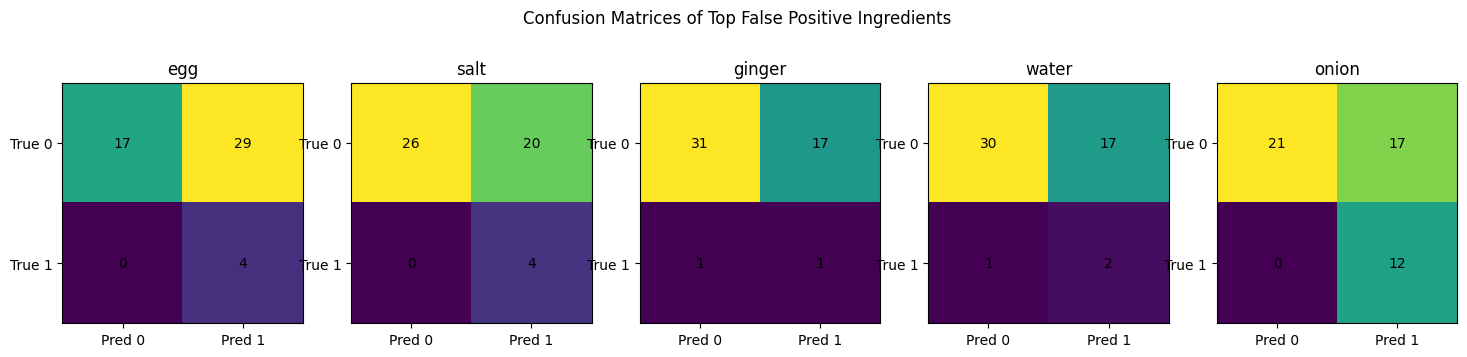

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# Select top 5 ingredients with highest FP
top_fp = df_confusion.sort_values("FP", ascending=False).head(5)

fig, axes = plt.subplots(1, 5, figsize=(18,4))

for i, row in enumerate(top_fp.itertuples()):
    mat = np.array([[row.TN, row.FP],
                    [row.FN, row.TP]])

    axes[i].imshow(mat)
    axes[i].set_title(row.Ingredient)
    axes[i].set_xticks([0,1])
    axes[i].set_yticks([0,1])
    axes[i].set_xticklabels(["Pred 0","Pred 1"])
    axes[i].set_yticklabels(["True 0","True 1"])

    for (r,c), val in np.ndenumerate(mat):
        axes[i].text(c, r, val, ha="center", va="center", fontsize=10)

plt.suptitle("Confusion Matrices of Top False Positive Ingredients")
plt.show()

In [24]:
def predict_with_threshold(image_path, threshold):
    _, preds = predict_ingredients(
        image_path=image_path,
        checkpoint_path=checkpoint_path,
        vocab_path="../data/processed/ingredient_vocab.json",
        min_prob=threshold
    )
    return [p[0] for p in preds]

# Compare thresholds
img_test = image_ids[0]
img_path = f"../data/raw/Food Images/{img_test}.jpg"

for t in [0.05, 0.1, 0.2, 0.3]:
    print(f"\nThreshold = {t}")
    print(predict_with_threshold(img_path, t))



Threshold = 0.05
Using device: mps
['egg', 'onion', 'salt', 'tomato', 'scallion']

Threshold = 0.1
Using device: mps
['egg', 'onion', 'salt']

Threshold = 0.2
Using device: mps
[]

Threshold = 0.3
Using device: mps
[]


# Overall Validation Conclusion

The Xception-based multi-label ingredient recognition model was evaluated using a comprehensive validation framework involving classification metrics, Hamming accuracy, predicted-versus-actual comparison, per-ingredient confusion matrices, and threshold sensitivity analysis.

The model achieved a **Hamming accuracy of 98.53%**, indicating that the majority of ingredient labels across all classes were correctly predicted. This demonstrates strong overall detection capability in a high-dimensional multi-label setting with 535 ingredient classes.

The **exact-match accuracy was 0.0**, which is expected in multi-label problems with a large number of possible ingredient combinations. This confirms that exact-match accuracy is not an appropriate primary metric for evaluating ingredient recognition performance.

The classification report and confusion matrix analysis revealed that the model exhibits:

- High recall, meaning most true ingredients are successfully detected.
- Low precision, due to frequent false positive predictions.
- A strong bias toward commonly occurring ingredients such as *egg, salt, onion,* and *water*.
- Reduced sensitivity toward rare ingredients such as nuts, spices, and garnishes.

Per-ingredient confusion matrices further confirmed that frequent ingredients have high true positive rates but also significantly high false positive rates, indicating an over-prediction tendency caused primarily by class imbalance in the training dataset.

Threshold sensitivity experiments demonstrated that prediction quality is highly dependent on probability threshold selection. Lower thresholds increase recall but introduce many false
